In [1]:
import numpy as np
from scipy.sparse import *
from sklearn.metrics.pairwise import pairwise_distances


def construct_W(X, **kwargs):
    """
    Construct the affinity matrix W through different ways

    Notes
    -----
    if kwargs is null, use the default parameter settings;
    if kwargs is not null, construct the affinity matrix according to parameters in kwargs

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    kwargs: {dictionary}
        parameters to construct different affinity matrix W:
        y: {numpy array}, shape (n_samples, 1)
            the true label information needed under the 'supervised' neighbor mode
        metric: {string}
            choices for different distance measures
            'euclidean' - use euclidean distance
            'cosine' - use cosine distance (default)
        neighbor_mode: {string}
            indicates how to construct the graph
            'knn' - put an edge between two nodes if and only if they are among the
                    k nearest neighbors of each other (default)
            'supervised' - put an edge between two nodes if they belong to same class
                    and they are among the k nearest neighbors of each other
        weight_mode: {string}
            indicates how to assign weights for each edge in the graph
            'binary' - 0-1 weighting, every edge receives weight of 1 (default)
            'heat_kernel' - if nodes i and j are connected, put weight W_ij = exp(-norm(x_i - x_j)/2t^2)
                            this weight mode can only be used under 'euclidean' metric and you are required
                            to provide the parameter t
            'cosine' - if nodes i and j are connected, put weight cosine(x_i,x_j).
                        this weight mode can only be used under 'cosine' metric
        k: {int}
            choices for the number of neighbors (default k = 5)
        t: {float}
            parameter for the 'heat_kernel' weight_mode
        fisher_score: {boolean}
            indicates whether to build the affinity matrix in a fisher score way, in which W_ij = 1/n_l if yi = yj = l;
            otherwise W_ij = 0 (default fisher_score = false)
        reliefF: {boolean}
            indicates whether to build the affinity matrix in a reliefF way, NH(x) and NM(x,y) denotes a set of
            k nearest points to x with the same class as x, and a different class (the class y), respectively.
            W_ij = 1 if i = j; W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y) (default reliefF = false)

    Output
    ------
    W: {sparse matrix}, shape (n_samples, n_samples)
        output affinity matrix W
    """

    # default metric is 'cosine'
    if 'metric' not in kwargs.keys():
        kwargs['metric'] = 'cosine'

    # default neighbor mode is 'knn' and default neighbor size is 5
    if 'neighbor_mode' not in kwargs.keys():
        kwargs['neighbor_mode'] = 'knn'
    if kwargs['neighbor_mode'] == 'knn' and 'k' not in kwargs.keys():
        kwargs['k'] = 5
    if kwargs['neighbor_mode'] == 'supervised' and 'k' not in kwargs.keys():
        kwargs['k'] = 5
    if kwargs['neighbor_mode'] == 'supervised' and 'y' not in kwargs.keys():
        print ('Warning: label is required in the supervised neighborMode!!!')
        exit(0)

    # default weight mode is 'binary', default t in heat kernel mode is 1
    if 'weight_mode' not in kwargs.keys():
        kwargs['weight_mode'] = 'binary'
    if kwargs['weight_mode'] == 'heat_kernel':
        if kwargs['metric'] != 'euclidean':
            kwargs['metric'] = 'euclidean'
        if 't' not in kwargs.keys():
            kwargs['t'] = 1
    elif kwargs['weight_mode'] == 'cosine':
        if kwargs['metric'] != 'cosine':
            kwargs['metric'] = 'cosine'

    # default fisher_score and reliefF mode are 'false'
    if 'fisher_score' not in kwargs.keys():
        kwargs['fisher_score'] = False
    if 'reliefF' not in kwargs.keys():
        kwargs['reliefF'] = False

    n_samples, n_features = np.shape(X)

    # choose 'knn' neighbor mode
    if kwargs['neighbor_mode'] == 'knn':
        k = kwargs['k']
        if kwargs['weight_mode'] == 'binary':
            if kwargs['metric'] == 'euclidean':
                # compute pairwise euclidean distances
                D = pairwise_distances(X)
                D **= 2
                # sort the distance matrix D in ascending order
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                # choose the k-nearest neighbors for each instance
                idx_new = idx[:, 0:k+1]
                G = np.zeros((n_samples*(k+1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order='F')
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            elif kwargs['metric'] == 'cosine':
                # normalize the data first
                X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
                # compute pairwise cosine distances
                D_cosine = np.dot(X, np.transpose(X))
                # sort the distance matrix D in descending order
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0:k+1]
                G = np.zeros((n_samples*(k+1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order='F')
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs['weight_mode'] == 'heat_kernel':
            t = kwargs['t']
            # compute pairwise euclidean distances
            D = pairwise_distances(X)
            D **= 2
            # sort the distance matrix D in ascending order
            dump = np.sort(D, axis=1)
            idx = np.argsort(D, axis=1)
            idx_new = idx[:, 0:k+1]
            dump_new = dump[:, 0:k+1]
            # compute the pairwise heat kernel distances
            dump_heat_kernel = np.exp(-dump_new/(2*t*t))
            G = np.zeros((n_samples*(k+1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order='F')
            G[:, 2] = np.ravel(dump_heat_kernel, order='F')
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs['weight_mode'] == 'cosine':
            # normalize the data first
            X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
            for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
            # compute pairwise cosine distances
            D_cosine = np.dot(X, np.transpose(X))
            # sort the distance matrix D in ascending order
            dump = np.sort(-D_cosine, axis=1)
            idx = np.argsort(-D_cosine, axis=1)
            idx_new = idx[:, 0:k+1]
            dump_new = -dump[:, 0:k+1]
            G = np.zeros((n_samples*(k+1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order='F')
            G[:, 2] = np.ravel(dump_new, order='F')
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

    # choose supervised neighborMode
    elif kwargs['neighbor_mode'] == 'supervised':
        k = kwargs['k']
        # get true labels and the number of classes
        y = kwargs['y']
        label = np.unique(y)
        n_classes = np.unique(y).size
        # construct the weight matrix W in a fisherScore way, W_ij = 1/n_l if yi = yj = l, otherwise W_ij = 0
        if kwargs['fisher_score'] is True:
            W = lil_matrix((n_samples, n_samples))
            for i in range(n_classes):
                class_idx = (y == label[i])
                class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])
                W[class_idx_all] = 1.0/np.sum(np.sum(class_idx))
            return W

        # construct the weight matrix W in a reliefF way, NH(x) and NM(x,y) denotes a set of k nearest
        # points to x with the same class as x, a different class (the class y), respectively. W_ij = 1 if i = j;
        # W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y)
        if kwargs['reliefF'] is True:
            # when xj in NH(xi)
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0:k+1]
                n_smp_class = (class_idx[idx_new[:]]).size
                if len(class_idx) <= k:
                    k = len(class_idx) - 1
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = 1.0/k
                id_now += n_smp_class
            W1 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            # when i = j, W_ij = 1
            for i in range(n_samples):
                W1[i, i] = 1
            # when x_j in NM(x_i, y)
            G = np.zeros((n_samples*k*(n_classes - 1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx1 = np.column_stack(np.where(y == label[i]))[:, 0]
                X1 = X[class_idx1, :]
                for j in range(n_classes):
                    if label[j] != label[i]:
                        class_idx2 = np.column_stack(np.where(y == label[j]))[:, 0]
                        X2 = X[class_idx2, :]
                        D = pairwise_distances(X1, X2)
                        idx = np.argsort(D, axis=1)
                        idx_new = idx[:, 0:k]
                        n_smp_class = len(class_idx1)*k
                        G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx1, (k, 1)).reshape(-1)
                        G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx2[idx_new[:]], order='F')
                        G[id_now:n_smp_class+id_now, 2] = -1.0/((n_classes-1)*k)
                        id_now += n_smp_class
            W2 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W2) > W2
            W2 = W2 - W2.multiply(bigger) + np.transpose(W2).multiply(bigger)
            W = W1 + W2
            return W

        if kwargs['weight_mode'] == 'binary':
            if kwargs['metric'] == 'euclidean':
                G = np.zeros((n_samples*(k+1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise euclidean distances for instances in class i
                    D = pairwise_distances(X[class_idx, :])
                    D **= 2
                    # sort the distance matrix D in ascending order for instances in class i
                    idx = np.argsort(D, axis=1)
                    idx_new = idx[:, 0:k+1]
                    n_smp_class = len(class_idx)*(k+1)
                    G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                    G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                    G[id_now:n_smp_class+id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            if kwargs['metric'] == 'cosine':
                # normalize the data first
                X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
                G = np.zeros((n_samples*(k+1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise cosine distances for instances in class i
                    D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                    # sort the distance matrix D in descending order for instances in class i
                    idx = np.argsort(-D_cosine, axis=1)
                    idx_new = idx[:, 0:k+1]
                    n_smp_class = len(class_idx)*(k+1)
                    G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                    G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                    G[id_now:n_smp_class+id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs['weight_mode'] == 'heat_kernel':
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                # sort the distance matrix D in ascending order for instances in class i
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0:k+1]
                dump_new = dump[:, 0:k+1]
                t = kwargs['t']
                # compute pairwise heat kernel distances for instances in class i
                dump_heat_kernel = np.exp(-dump_new/(2*t*t))
                n_smp_class = len(class_idx)*(k+1)
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = np.ravel(dump_heat_kernel, order='F')
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs['weight_mode'] == 'cosine':
            # normalize the data first
            X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
            for i in range(n_samples):
                X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                # sort the distance matrix D in descending order for instances in class i
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0:k+1]
                dump_new = -dump[:, 0:k+1]
                n_smp_class = len(class_idx)*(k+1)
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = np.ravel(dump_new, order='F')
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
/var/folders/v8/yj_gmdgd47l6hvz6s8ldkqfc0000gn/T/ipykernel_59962/3265394307.py:7: SyntaxWarning: invalid escape sequence '\i'
  """


## Open Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import diags
from sklearn.linear_model import Lasso
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load the train and test datasets
data_train = pd.read_csv('/Users/ludoviclepic/.cache/kagglehub/datasets/uciml/human-activity-recognition-with-smartphones/versions/2/train.csv')
data_test = pd.read_csv('/Users/ludoviclepic/.cache/kagglehub/datasets/uciml/human-activity-recognition-with-smartphones/versions/2/test.csv')

# Split features and target for both train and test
X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

## All features

In [3]:
# Train on all features
classifier_all = RandomForestClassifier(random_state=42, class_weight="balanced")
classifier_all.fit(X_scaled, y_encoded)
X_test_scaled = scaler.transform(X_test)
y_pred_all = classifier_all.predict(X_test_scaled)

# Evaluate accuracy
accuracy_all_features = accuracy_score(y_test_encoded, y_pred_all)
print(f"Accuracy using all {X_test.shape} Features: {accuracy_all_features:.2f}")


Accuracy using all (2947, 562) Features: 0.93


## Similarity

### Laplacian Score

In [4]:
def lap_score(X, **kwargs):
    """
    This function implements the laplacian score feature selection, steps are as follows:
    1. Construct the affinity matrix W if it is not specified
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Laplacian score for the r-th feature is score = (fr_hat'*L*fr_hat)/(fr_hat'*D*fr_hat)

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    kwargs: {dictionary}
        W: {sparse matrix}, shape (n_samples, n_samples)
            input affinity matrix

    Output
    ------
    score: {numpy array}, shape (n_features,)
        laplacian score for each feature

    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    """

    # if 'W' is not specified, use the default W
    if 'W' not in kwargs.keys():
        W = construct_W(X)
    # construct the affinity matrix W
    W = kwargs['W']
    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000

    # compute laplacian score for all features
    score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in ascending order according to their laplacian scores, the smaller the laplacian score is, the more
    important the feature is
    """
    idx = np.argsort(score, 0)
    return idx

Accuracy with top 562 features: 0.64


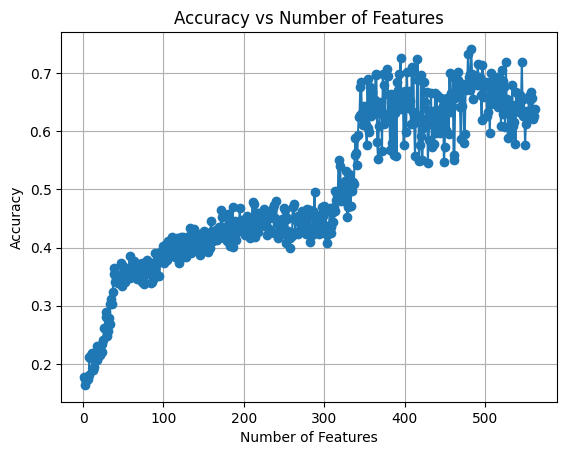

Best number of features: 483
Best accuracy: 0.74


In [53]:
from IPython.display import clear_output
W = construct_W(X_scaled)  # Affinity matrix
laplacian_scores = lap_score(X_scaled, W=W)
ranked_features = feature_ranking(laplacian_scores)

best_accuracy = 0
best_num_features = 0
best_model = None

num_features_list = []
accuracy_list = []

for num_features in range(1, len(ranked_features) + 1, 25):
    top_laplacian_features = ranked_features[:num_features]
    
    # Subset the train and test data with top Laplacian features
    X_train_laplacian = X_scaled[:, top_laplacian_features]
    X_test_scaled = scaler.transform(X_test)
    X_test_laplacian = X_test_scaled[:, top_laplacian_features]
    
    # Train and evaluate the classifier
    classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
    classifier.fit(X_train_laplacian, y_encoded)
    y_pred_laplacian = classifier.predict(X_test_laplacian)
    
    # Evaluate accuracy
    accuracy_laplacian = accuracy_score(y_test_encoded, y_pred_laplacian)
    clear_output(wait=True)
    print(f"Accuracy with top {num_features} features: {accuracy_laplacian:.2f}")

    num_features_list.append(num_features)
    accuracy_list.append(accuracy_laplacian)

    plt.clf()
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Features')
    plt.grid(True)
    plt.plot(num_features_list, accuracy_list, marker='o')
    
    # Track the best model
    if accuracy_laplacian > best_accuracy:
        best_accuracy = accuracy_laplacian
        best_num_features = num_features
        best_model = classifier
    plt.show()

print(f"Best number of features: {best_num_features}")
print(f"Best accuracy: {best_accuracy:.2f}")

### Fisher Score

In [54]:
def fisher_score(X, y):
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels

    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature

    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """

    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

Accuracy using Fisher-Selected Features: 0.61


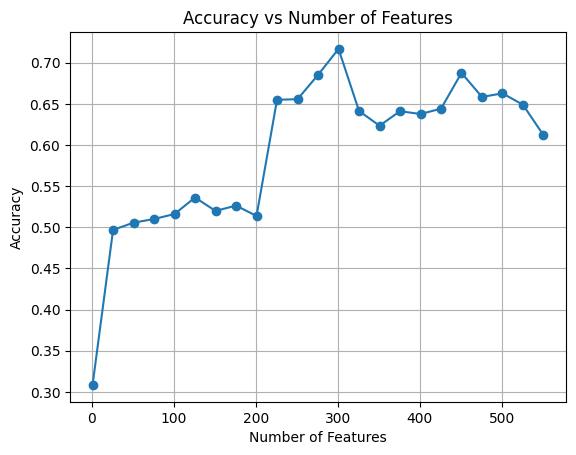

In [57]:
# Fisher Score Pipeline
# Compute Fisher Scores for the dataset
fisher_scores = fisher_score(X_scaled, y_encoded)
ranked_features_fisher = feature_ranking(fisher_scores)

best_accuracy_fisher = 0
best_num_features_fisher = 0
best_model_fisher = None

num_features_list_fisher = []
accuracy_list_fisher = []

for num_features in range(1, len(ranked_features) + 1, 25):
    top_fisher_features = ranked_features_fisher[:num_features]
    #print("Top Fisher Features:", top_fisher_features)

    # Subset the train and test data with top Fisher features
    X_train_fisher = X_scaled[:, top_fisher_features]
    X_test_scaled = scaler.transform(X_test)
    X_test_fisher = X_test_scaled[:, top_fisher_features]

    # Train and evaluate the classifier
    classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
    classifier.fit(X_train_fisher, y_encoded)
    y_pred_fisher = classifier.predict(X_test_fisher)

    # Evaluate accuracy
    accuracy_fisher = accuracy_score(y_test_encoded, y_pred_fisher)
    clear_output(wait=True)
    print(f"Accuracy using Fisher-Selected Features: {accuracy_fisher:.2f}")

    num_features_list_fisher.append(num_features)
    accuracy_list_fisher.append(accuracy_fisher)

    plt.clf()
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Features')
    plt.grid(True)
    plt.plot(num_features_list_fisher, accuracy_list_fisher, marker='o')

    if accuracy_fisher > best_accuracy_fisher:
        best_accuracy_fisher = accuracy_fisher
        best_num_features_fisher = num_features
        best_model_fisher = classifier
    plt.show()

print(f"Best number of features: {best_num_features_fisher}")
print(f"Best accuracy: {best_accuracy_fisher:.2f}")


## Theoretical Information Based

### CMIM

In [85]:
# Written by Greg Ver Steeg (http://www.isi.edu/~gregv/npeet.html)

import scipy.spatial as ss
from scipy.special import digamma
from math import log
import numpy.random as nr
import numpy as np
import random


# continuous estimators

def entropy(x, k=3, base=2):
    """
    The classic K-L k-nearest neighbor continuous entropy estimator x should be a list of vectors,
    e.g. x = [[1.3],[3.7],[5.1],[2.4]] if x is a one-dimensional scalar and we have four samples
    """

    assert k <= len(x)-1, "Set k smaller than num. samples - 1"
    d = len(x[0])
    N = len(x)
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    tree = ss.cKDTree(x)
    nn = [tree.query(point, k+1, p=float('inf'))[0][k] for point in x]
    const = digamma(N)-digamma(k) + d*log(2)
    return (const + d*np.mean(map(log, nn)))/log(base)


def mi(x, y, k=3, base=2):
    """
    Mutual information of x and y; x, y should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    y = [list(p + intens * nr.rand(len(y[0]))) for p in y]
    points = zip2(x, y)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = ss.cKDTree(points)
    dvec = [tree.query(point, k+1, p=float('inf'))[0][k] for point in points]
    a, b, c, d = avgdigamma(x, dvec), avgdigamma(y, dvec), digamma(k), digamma(len(x))
    return (-a-b+c+d)/log(base)


def cmi(x, y, z, k=3, base=2):
    """
    Mutual information of x and y, conditioned on z; x, y, z should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    y = [list(p + intens * nr.rand(len(y[0]))) for p in y]
    z = [list(p + intens * nr.rand(len(z[0]))) for p in z]
    points = zip2(x, y, z)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = ss.cKDTree(points)
    dvec = [tree.query(point, k+1, p=float('inf'))[0][k] for point in points]
    a, b, c, d = avgdigamma(zip2(x, z), dvec), avgdigamma(zip2(y, z), dvec), avgdigamma(z, dvec), digamma(k)
    return (-a-b+c+d)/log(base)


def kldiv(x, xp, k=3, base=2):
    """
    KL Divergence between p and q for x~p(x), xp~q(x); x, xp should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    assert k <= len(xp) - 1, "Set k smaller than num. samples - 1"
    assert len(x[0]) == len(xp[0]), "Two distributions must have same dim."
    d = len(x[0])
    n = len(x)
    m = len(xp)
    const = log(m) - log(n-1)
    tree = ss.cKDTree(x)
    treep = ss.cKDTree(xp)
    nn = [tree.query(point, k+1, p=float('inf'))[0][k] for point in x]
    nnp = [treep.query(point, k, p=float('inf'))[0][k-1] for point in x]
    return (const + d*np.mean(map(log, nnp))-d*np.mean(map(log, nn)))/log(base)


# Discrete estimators
def entropyd(sx, base=2):
    """
    Discrete entropy estimator given a list of samples which can be any hashable object
    """

    return entropyfromprobs(hist(sx), base=base)


def midd(x, y):
    """
    Discrete mutual information estimator given a list of samples which can be any hashable object
    """

    return -entropyd(list(zip(x, y)))+entropyd(x)+entropyd(y)


def cmidd(x, y, z):
    """
    Discrete mutual information estimator given a list of samples which can be any hashable object
    """

    return entropyd(list(zip(y, z)))+entropyd(list(zip(x, z)))-entropyd(list(zip(x, y, z)))-entropyd(z)


def hist(sx):
    # Histogram from list of samples
    d = dict()
    for s in sx:
        d[s] = d.get(s, 0) + 1
    return map(lambda z: float(z)/len(sx), d.values())


def entropyfromprobs(probs, base=2):
    # Turn a normalized list of probabilities of discrete outcomes into entropy (base 2)
    return -sum(map(elog, probs))/log(base)


def elog(x):
    # for entropy, 0 log 0 = 0. but we get an error for putting log 0
    if x <= 0. or x >= 1.:
        return 0
    else:
        return x*log(x)


# Mixed estimators
def micd(x, y, k=3, base=2, warning=True):
    """ If x is continuous and y is discrete, compute mutual information
    """

    overallentropy = entropy(x, k, base)
    n = len(y)
    word_dict = dict()
    for sample in y:
        word_dict[sample] = word_dict.get(sample, 0) + 1./n
    yvals = list(set(word_dict.keys()))

    mi = overallentropy
    for yval in yvals:
        xgiveny = [x[i] for i in range(n) if y[i] == yval]
        if k <= len(xgiveny) - 1:
            mi -= word_dict[yval]*entropy(xgiveny, k, base)
        else:
            if warning:
                print("Warning, after conditioning, on y={0} insufficient data. Assuming maximal entropy in this case.".format(yval))
            mi -= word_dict[yval]*overallentropy
    return mi  # units already applied


# Utility functions
def vectorize(scalarlist):
    """
    Turn a list of scalars into a list of one-d vectors
    """

    return [(x,) for x in scalarlist]


def shuffle_test(measure, x, y, z=False, ns=200, ci=0.95, **kwargs):
    """
    Shuffle test
    Repeatedly shuffle the x-values and then estimate measure(x,y,[z]).
    Returns the mean and conf. interval ('ci=0.95' default) over 'ns' runs, 'measure' could me mi,cmi,
    e.g. Keyword arguments can be passed. Mutual information and CMI should have a mean near zero.
    """

    xp = x[:]   # A copy that we can shuffle
    outputs = []
    for i in range(ns):
        random.shuffle(xp)
        if z:
            outputs.append(measure(xp, y, z, **kwargs))
        else:
            outputs.append(measure(xp, y, **kwargs))
    outputs.sort()
    return np.mean(outputs), (outputs[int((1.-ci)/2*ns)], outputs[int((1.+ci)/2*ns)])


# Internal functions
def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    N = len(points)
    tree = ss.cKDTree(points)
    avg = 0.
    for i in range(N):
        dist = dvec[i]
        # subtlety, we don't include the boundary point,
        # but we are implicitly adding 1 to kraskov def bc center point is included
        num_points = len(tree.query_ball_point(points[i], dist-1e-15, p=float('inf')))
        avg += digamma(num_points)/N
    return avg


def zip2(*args):
    # zip2(x,y) takes the lists of vectors and makes it a list of vectors in a joint space
    # E.g. zip2([[1],[2],[3]],[[4],[5],[6]]) = [[1,4],[2,5],[3,6]]
    return [sum(sublist, []) for sublist in zip(*args)]

In [86]:
def cmim(X, y, **kwargs):
    """
    This function implements the CMIM feature selection.
    The scoring criteria is calculated based on the formula j_cmim=I(f;y)-max_j(I(fj;f)-I(fj;f|y))

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        Input data, guaranteed to be a discrete numpy array
    y: {numpy array}, shape (n_samples,)
        guaranteed to be a numpy array
    kwargs: {dictionary}
        n_selected_features: {int}
            number of features to select

    Output
    ------
    F: {numpy array}, shape (n_features,)
        index of selected features, F[0] is the most important feature
    J_CMIM: {numpy array}, shape: (n_features,)
        corresponding objective function value of selected features
    MIfy: {numpy array}, shape: (n_features,)
        corresponding mutual information between selected features and response

    Reference
    ---------
    Brown, Gavin et al. "Conditional Likelihood Maximisation: A Unifying Framework for Information Theoretic Feature Selection." JMLR 2012.
    """

    n_samples, n_features = X.shape
    # index of selected features, initialized to be empty
    F = []
    # Objective function value for selected features
    J_CMIM = []
    # Mutual information between feature and response
    MIfy = []
    # indicate whether the user specifies the number of features
    is_n_selected_features_specified = False

    if 'n_selected_features' in kwargs.keys():
        n_selected_features = kwargs['n_selected_features']
        is_n_selected_features_specified = True

    # t1 stores I(f;y) for each feature f
    t1 = np.zeros(n_features)

    # max stores max(I(fj;f)-I(fj;f|y)) for each feature f
    # we assign an extreme small value to max[i] ito make it is smaller than possible value of max(I(fj;f)-I(fj;f|y))
    max = -10000000*np.ones(n_features)
    for i in range(n_features):
        f = X[:, i]
        t1[i] = midd(f, y)

    # make sure that j_cmi is positive at the very beginning
    j_cmim = 1

    while True:
        if len(F) == 0:
            # select the feature whose mutual information is the largest
            idx = np.argmax(t1)
            F.append(idx)
            J_CMIM.append(t1[idx])
            MIfy.append(t1[idx])
            f_select = X[:, idx]

        if is_n_selected_features_specified:
            if len(F) == n_selected_features:
                break
        else:
            if j_cmim <= 0:
                break

        # we assign an extreme small value to j_cmim to ensure it is smaller than all possible values of j_cmim
        j_cmim = -1000000000000
        for i in range(n_features):
            if i not in F:
                f = X[:, i]
                t2 = midd(f_select, f)
                t3 = cmidd(f_select, f, y)
                if t2-t3 > max[i]:
                        max[i] = t2-t3
                # calculate j_cmim for feature i (not in F)
                t = t1[i] - max[i]
                # record the largest j_cmim and the corresponding feature index
                if t > j_cmim:
                    j_cmim = t
                    idx = i
        F.append(idx)
        J_CMIM.append(j_cmim)
        MIfy.append(t1[idx])
        f_select = X[:, idx]

    return np.array(F), np.array(J_CMIM), np.array(MIfy)

In [ ]:
# CMIM Feature Selection Pipeline
# Compute CMIM Scores for the dataset
num_features_to_test = len(X_scaled[0])  # You can reduce this if testing all features is too costly
selected_features_cmim, _, _ = cmim(X_scaled, y_encoded, n_selected_features=num_features_to_test)

best_accuracy_cmim = 0
best_num_features_cmim = 0
best_model_cmim = None

num_features_list_cmim = []
accuracy_list_cmim = []

# Iterate through the number of selected features
for num_features in range(1, len(selected_features_cmim) + 1, 25):  # Adjust step size as needed
    top_cmim_features = selected_features_cmim[:num_features]
    print(top_cmim_features)
    # Subset the train and test data with top CMIM features
    X_train_cmim = X_scaled[:, top_cmim_features]
    X_test_scaled = scaler.transform(X_test)
    X_test_cmim = X_test_scaled[:, top_cmim_features]

    # Train and evaluate the classifier
    classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
    classifier.fit(X_train_cmim, y_encoded)
    y_pred_cmim = classifier.predict(X_test_cmim)

    # Evaluate accuracy
    accuracy_cmim = accuracy_score(y_test_encoded, y_pred_cmim)
    clear_output(wait=True)
    print(f"Accuracy using CMIM-Selected Features: {accuracy_cmim:.2f}")

    num_features_list_cmim.append(num_features)
    accuracy_list_cmim.append(accuracy_cmim)

    plt.clf()
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Features (CMIM)')
    plt.grid(True)
    plt.plot(num_features_list_cmim, accuracy_list_cmim, marker='o')

    if accuracy_cmim > best_accuracy_cmim:
        best_accuracy_cmim = accuracy_cmim
        best_num_features_cmim = num_features
        best_model_cmim = classifier
    plt.show()

print(f"Best number of features (CMIM): {best_num_features_cmim}")
print(f"Best accuracy (CMIM): {best_accuracy_cmim:.2f}")


## Sparse Learning Based

### GOSCAR

In [5]:
def goscar_loss(beta, X, y, lambda1, lambda2):
    """
    Loss function for GOSCAR regularization.
    """
    residual = y - np.dot(X, beta)
    l1_norm = np.sum(np.abs(beta))
    pairwise_penalty = np.sum(np.abs(beta)[:, None] + np.abs(beta)[None, :]) - np.sum(np.abs(beta))  # Optimized group penalty
    return np.sum(residual**2) / 2 + lambda1 * l1_norm + lambda2 * pairwise_penalty

# Solve the GOSCAR optimization problem
def goscar_feature_selection(X, y, lambda1=0.1, lambda2=0.1):
    """
    Perform GOSCAR feature selection.
    """
    n_features = X.shape[1]
    initial_beta = np.zeros(n_features)
    result = minimize(
        goscar_loss,
        initial_beta,
        args=(X, y, lambda1, lambda2),
        method="L-BFGS-B",
        options={"disp": False},
    )
    return result.x  # Optimized coefficients


In [ ]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Solve GOSCAR with higher regularization parameters to enforce sparsity
lambda1, lambda2 = 0.5, 0.5  # Adjusted based on experimentation
goscar_coefficients = goscar_feature_selection(X_scaled, y_encoded, lambda1=lambda1, lambda2=lambda2)

# Select features
threshold = 1e-2
selected_features = np.where(np.abs(goscar_coefficients) > threshold)[0]
print(f"Selected Features ({len(selected_features)})(GOSCAR): {selected_features}")

# Subset train and test data
X_train_goscar = X_scaled[:, selected_features]
X_test_goscar = X_test_scaled[:, selected_features]

# Train and evaluate classifier
classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
classifier.fit(X_train_goscar, y_encoded)
y_pred_goscar = classifier.predict(X_test_goscar)

# Evaluate accuracy
accuracy_goscar = accuracy_score(y_test_encoded, y_pred_goscar)
print(f"Accuracy using GOSCAR-Selected Features: {accuracy_goscar:.2f}")

## Statistical Method

In [36]:
def low_variance_feature_selection(X, threshold):
    variances = np.var(X, axis=0)
    selected_features = np.where(variances > threshold)[0]
    X_selected = X.iloc[:, selected_features]
    return X_selected, selected_features


In [63]:
var = X_train.var()
mean = var.mean()
mean

np.float64(0.24238879578465472)

In [68]:
# Apply low variance feature selection before scaling
thresholds = [0.025, 0.05, 0.1, 0.2, 0.5, 0.7]  # Example threshold

best_accuracy_lv = 0
best_num_features_lv = 0
best_model_lv = None
best_threshold = 0

num_features_list_lv = []
accuracy_list_lv = []

for threshold in thresholds:
    X_train_low_variance, selected_features = low_variance_feature_selection(X_train, threshold)

    #print("Selected Features (Low Variance):", selected_features)

    # Standardize the selected features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_low_variance)

    # Subset and scale the test data with the same selected features
    X_test_low_variance = X_test.iloc[:, selected_features]
    X_test_scaled = scaler.transform(X_test_low_variance)

    # Train and evaluate the classifier
    classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
    classifier.fit(X_train_scaled, y_encoded)
    y_pred_low_variance = classifier.predict(X_test_scaled)

    # Evaluate accuracy
    accuracy_low_variance = accuracy_score(y_test_encoded, y_pred_low_variance)
    print(f"Accuracy theshold: {threshold} using Low Variance-Selected Features: {accuracy_low_variance:.2f}")

    if accuracy_low_variance > best_accuracy_lv:
        best_accuracy_lv = accuracy_low_variance
        best_num_features_lv = len(selected_features)
        best_threshold = threshold
        best_model_lv = classifier

print(f"Best number of features: {best_num_features_lv}")
print(f"Best accuracy: {best_accuracy_lv:.2f}")

Accuracy theshold: 0.025 using Low Variance-Selected Features: 0.92
Accuracy theshold: 0.05 using Low Variance-Selected Features: 0.92
Accuracy theshold: 0.1 using Low Variance-Selected Features: 0.90
Accuracy theshold: 0.2 using Low Variance-Selected Features: 0.89
Accuracy theshold: 0.5 using Low Variance-Selected Features: 0.54
Accuracy theshold: 0.7 using Low Variance-Selected Features: 0.17
Best number of features: 455
Best accuracy: 0.92


## Evaluate Best model

In [83]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Assume X and y are predefined datasets
# Feature indices based on selected features
ranked_features = feature_ranking(lap_score(X_scaled, W=W))
top_laplacian_features = ranked_features[:best_num_features]
X_train_laplacian = X_scaled[:, top_laplacian_features]

fisher_scores = fisher_score(X_scaled, y_encoded)
ranked_features_fisher = feature_ranking(fisher_scores)
top_fisher_features = ranked_features_fisher[:best_num_features_fisher]
X_train_fisher = X_scaled[:, top_fisher_features]

lambda1, lambda2 = 0.5, 0.5  
goscar_coefficients = goscar_feature_selection(X_scaled, y_encoded, lambda1=lambda1, lambda2=lambda2)
threshold = 1e4
selected_features = np.where(np.abs(goscar_coefficients) > threshold)[0]
X_train_goscar = X_scaled[:, selected_features]

X_train_low_variance, selected_features = low_variance_feature_selection(X_train, threshold=best_threshold)

# Initialize classifier
clf = RandomForestClassifier(random_state=42)

# Perform cross-validation
cv_laplacian = cross_val_score(clf, X_train_laplacian, y_encoded, cv=5, scoring='accuracy').mean()
cv_fisher = cross_val_score(clf, X_train_fisher, y_encoded, cv=5, scoring='accuracy').mean()
cv_goscar = cross_val_score(clf, X_train_goscar, y_encoded, cv=5, scoring='accuracy').mean()
cv_low_variance = cross_val_score(clf, X_train_low_variance, y_encoded, cv=5, scoring='accuracy').mean()
cv_all = cross_val_score(clf, X_train, y_encoded, cv=5, scoring='accuracy').mean()

# Compare the results
print("Cross-Validation Accuracy:")
print(f"Laplacian Features: {cv_laplacian:.3f}")
print(f"Fisher Features: {cv_fisher:.3f}")
print(f"Low Variance Features: {cv_low_variance:.3f}")
print(f"All Features: {cv_all:.3f}")

Cross-Validation Accuracy:
Laplacian Features: 0.916
Fisher Features: 0.914
Low Variance Features: 0.914
All Features: 0.917
